Train accuracy: 0.9005524861878453
Test accuracy : 0.8351648351648352
              precision    recall  f1-score   support

        High       0.87      0.82      0.84        49
         Low       0.80      0.86      0.83        42

    accuracy                           0.84        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.84      0.84      0.84        91



/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


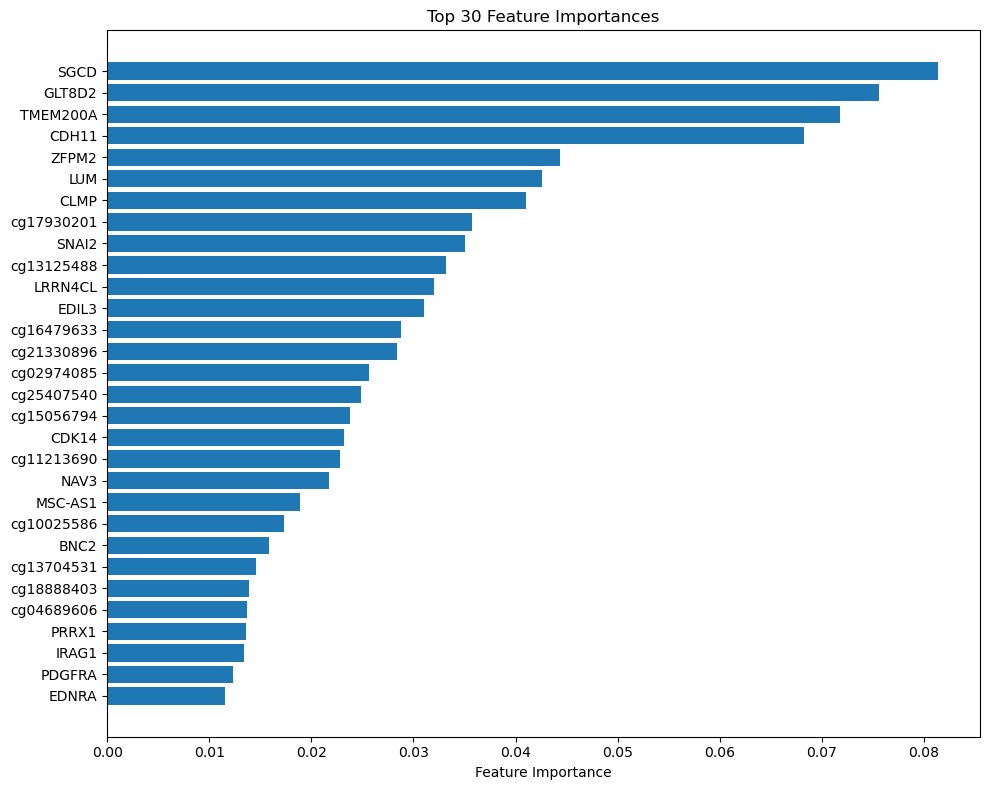

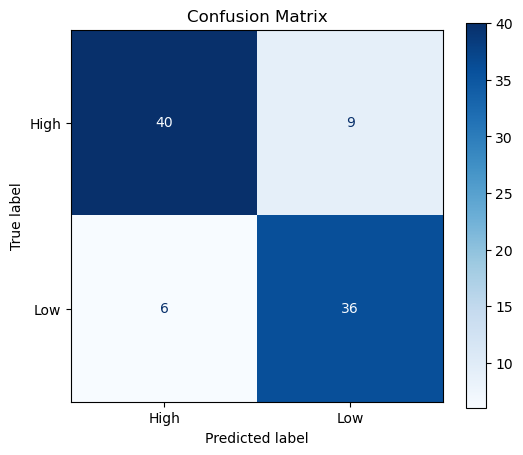

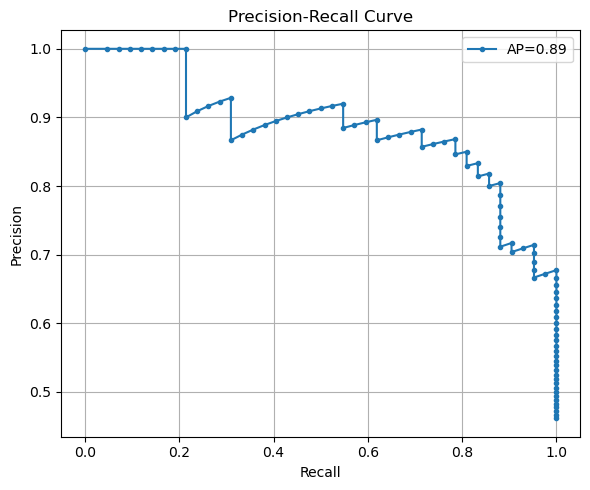

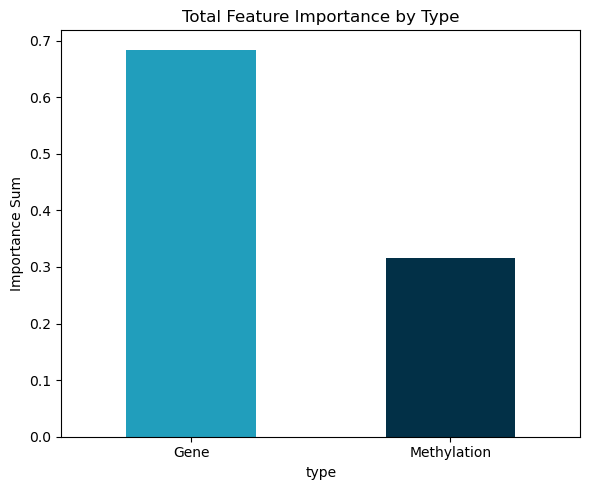

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, average_precision_score
import xgboost as xgb

# ========================
# 1. load data
# ========================
label_df = pd.read_csv('LUAD_MIR100HG_Expression_Levels.csv', index_col=0)
gene_expr_df = pd.read_csv('LUAD_Model_Gene_Expression_Features.csv', index_col=0)
methylation_df = pd.read_csv('LUAD_Model_Methylation_Features.csv', index_col=0)


# ========================
# 2. Transposed feature data (no TF)
# ========================
gene_expr_df_t = gene_expr_df.T
methylation_df_t = methylation_df.T

# ========================
# 3. Obtain public samples
# ========================
common_samples = list(set(gene_expr_df_t.index) & set(methylation_df_t.index))
gene_expr_df_t = gene_expr_df_t.loc[common_samples]
methylation_df_t = methylation_df_t.loc[common_samples]

# ========================
# 4. Label Treatment
# ========================
label_df = label_df.reset_index(drop=True).set_index("Sample_ID")
label_df = label_df.reindex(gene_expr_df_t.index)
y = label_df["Group"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Delete MIR100HG to prevent tag leakage
if 'MIR100HG' in gene_expr_df_t.columns:
    gene_expr_df_t = gene_expr_df_t.drop(columns=['MIR100HG'])

# ========================
# 5. Feature selection (no TF)
# ========================
selector_gene = SelectKBest(score_func=f_classif, k=30)
gene_selected = selector_gene.fit_transform(gene_expr_df_t, y_encoded)
gene_selected_cols = gene_expr_df_t.columns[selector_gene.get_support(indices=True)]
gene_selected_df = pd.DataFrame(gene_selected, index=gene_expr_df_t.index, columns=gene_selected_cols)

selector_methyl = SelectKBest(score_func=f_classif, k=30)
methyl_selected = selector_methyl.fit_transform(methylation_df_t, y_encoded)
methyl_selected_cols = methylation_df_t.columns[selector_methyl.get_support(indices=True)]
methyl_selected_df = pd.DataFrame(methyl_selected, index=methylation_df_t.index, columns=methyl_selected_cols)

# ========================
# 6. Combined gene expression + methylation characteristics
# ========================
X_final = pd.concat([gene_selected_df, methyl_selected_df], axis=1)

# ========================
# 7. Divide the training test set
# ========================
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

# ========================
# 8. model training
# ========================
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=1.0,
    reg_lambda=3.0,
    max_depth=2,
    n_estimators=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train.to_numpy(), y_train)

# ========================
# 9. model evaluation
# ========================
y_pred = model.predict(X_test.to_numpy())
y_proba = model.predict_proba(X_test.to_numpy())[:, 1]
print("Train accuracy:", model.score(X_train.to_numpy(), y_train))
print("Test accuracy :", model.score(X_test.to_numpy(), y_test))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ========================
# 10. Visual evaluation
# ========================

importances = model.feature_importances_
feature_names = X_final.columns
indices = np.argsort(importances)[-30:][::-1]
plt.figure(figsize=(10, 8))
plt.barh(range(30), importances[indices], align='center')
plt.yticks(range(30), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Confusion matrix heat map
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Precision - recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# The proportion of importance of various characteristics
feature_types = []
for col in X_final.columns:
    if col in methyl_selected_df.columns:
        feature_types.append("Methylation")
    else:
        feature_types.append("Gene")

importance_df = pd.DataFrame({
    "feature": X_final.columns,
    "importance": model.feature_importances_,
    "type": feature_types
})

grouped = importance_df.groupby("type")["importance"].sum()
plt.figure(figsize=(6, 5))
grouped.plot(kind='bar', color=['#219ebc', '#023047'])
plt.title("Total Feature Importance by Type")
plt.ylabel("Importance Sum")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


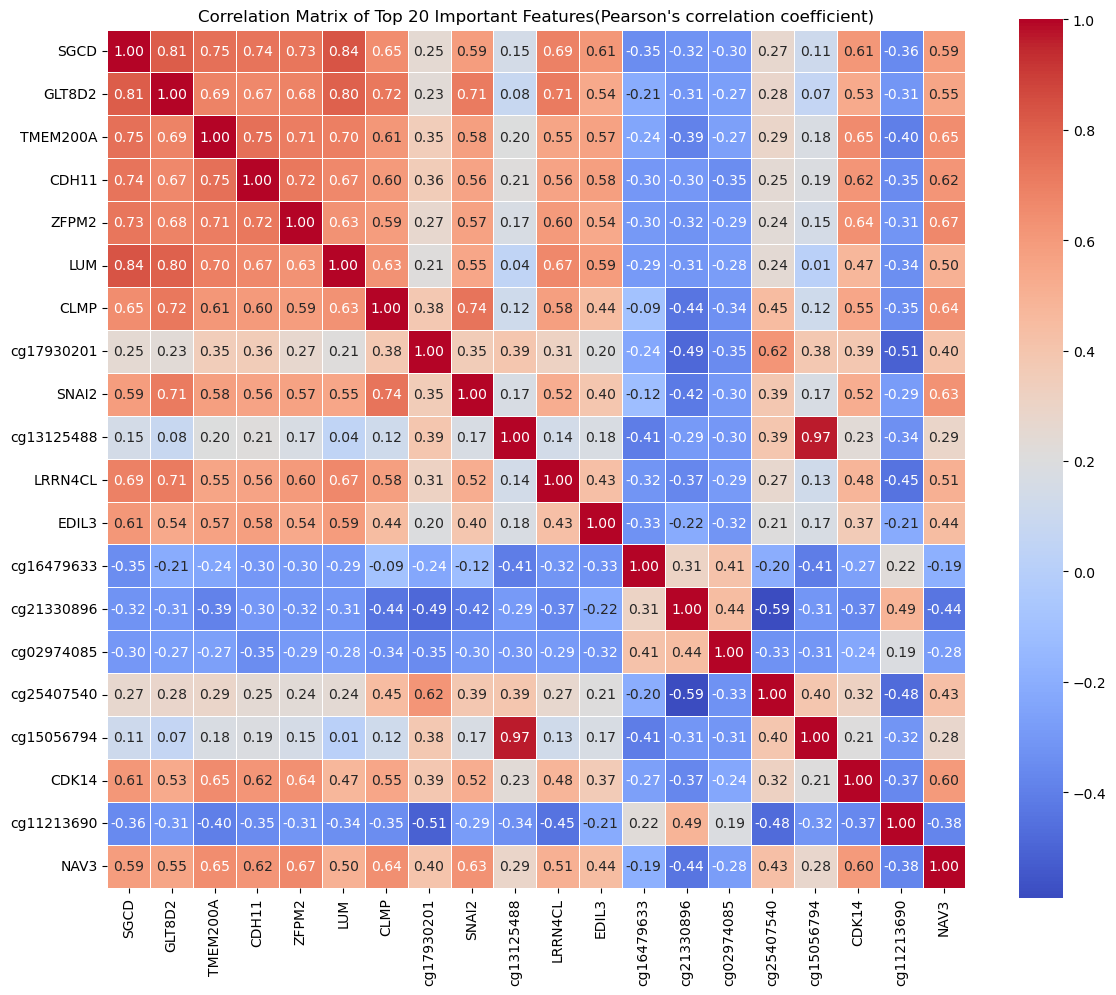

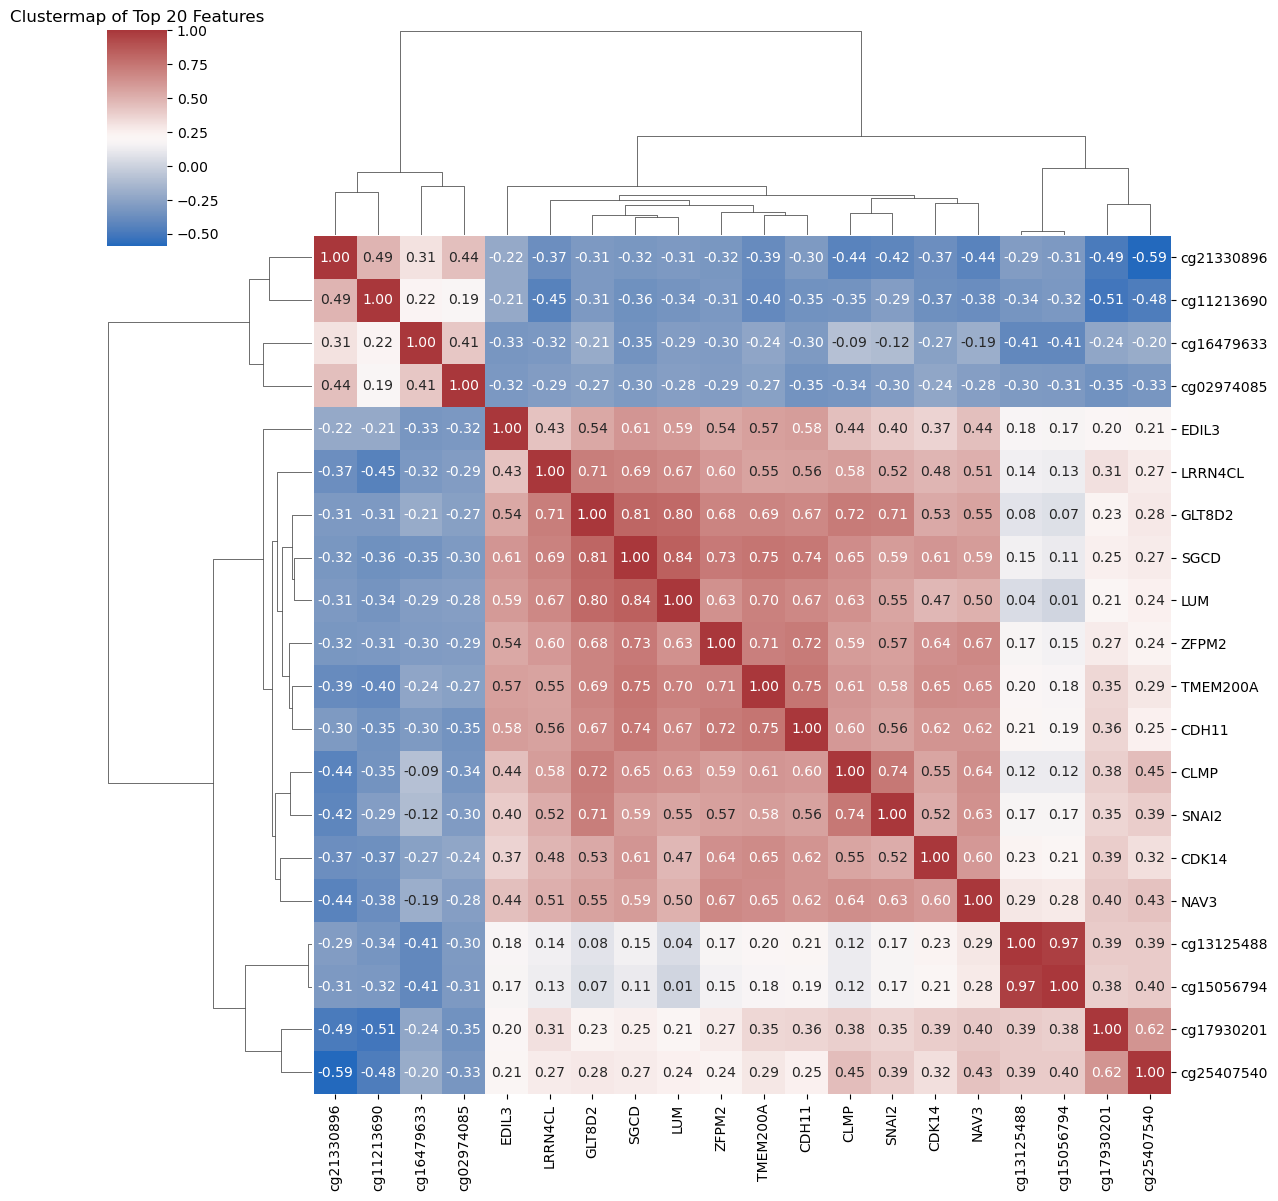

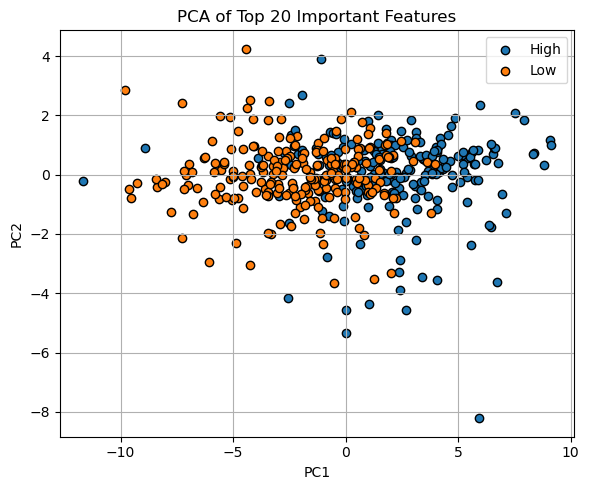

In [ ]:
# Study the relationships among the top 20 most significant features
# Get the names of the top 20 most important features
top_20_indices = np.argsort(importances)[-20:][::-1]
top_20_features = [feature_names[i] for i in top_20_indices]

top_20_df = X_final[top_20_features]

# Visualize the Pearson correlation coefficient heat map
import seaborn as sns

plt.figure(figsize=(12, 10))
corr_matrix = top_20_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Top 20 Important Features(Pearson's correlation coefficient)")
plt.tight_layout()
plt.show()

# Cluster these features (hierarchical clustering + heat map)）
sns.clustermap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", figsize=(12, 12))
plt.title("Clustermap of Top 20 Features")
plt.show()

# Dimensionality Reduction Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(top_20_df)

# Dimensionality Reduction Visualization (Group Drawing Methodplt.figure(figsize=(6, 5))
for label in np.unique(y_encoded):
    idx = y_encoded == label
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        label=le.inverse_transform([label])[0],
        edgecolor='k'
    )

plt.title("PCA of Top 20 Important Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



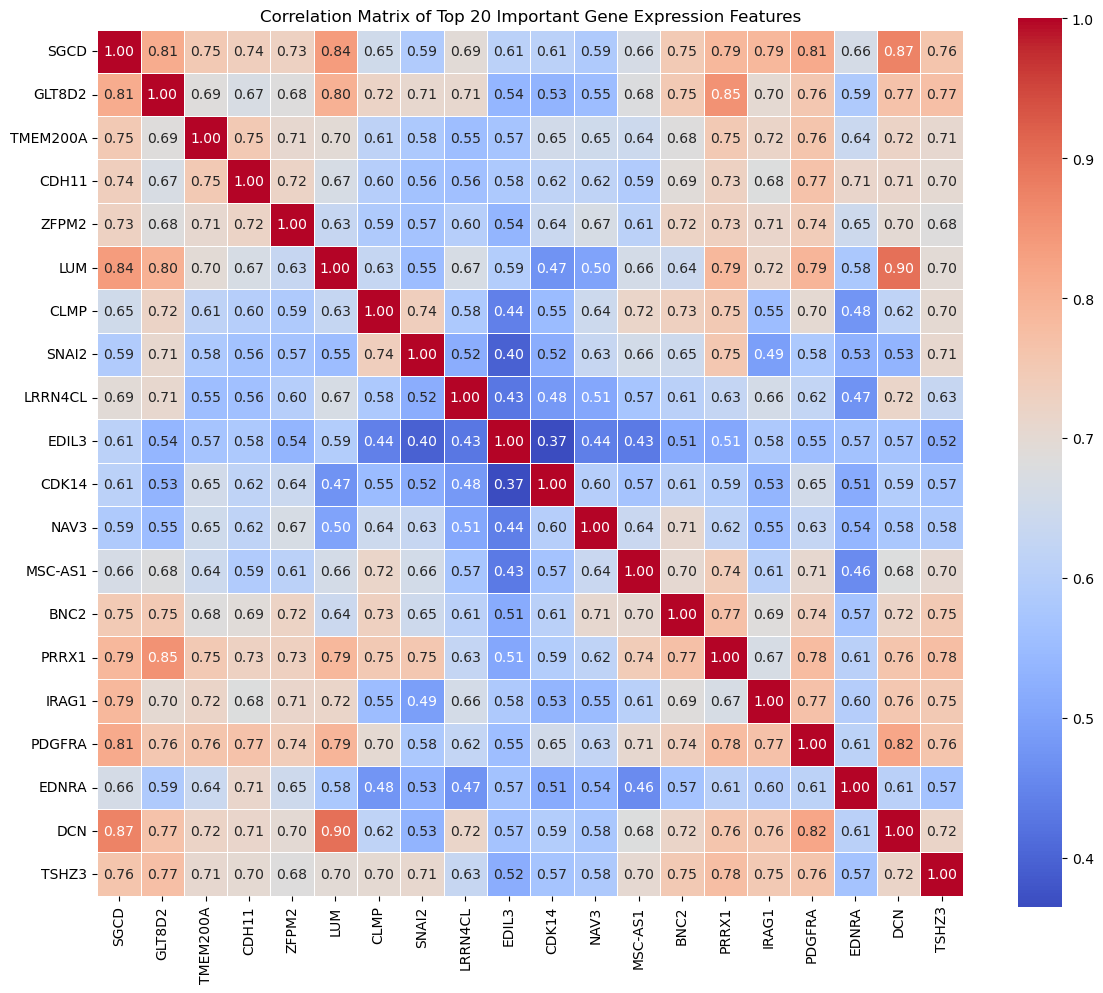

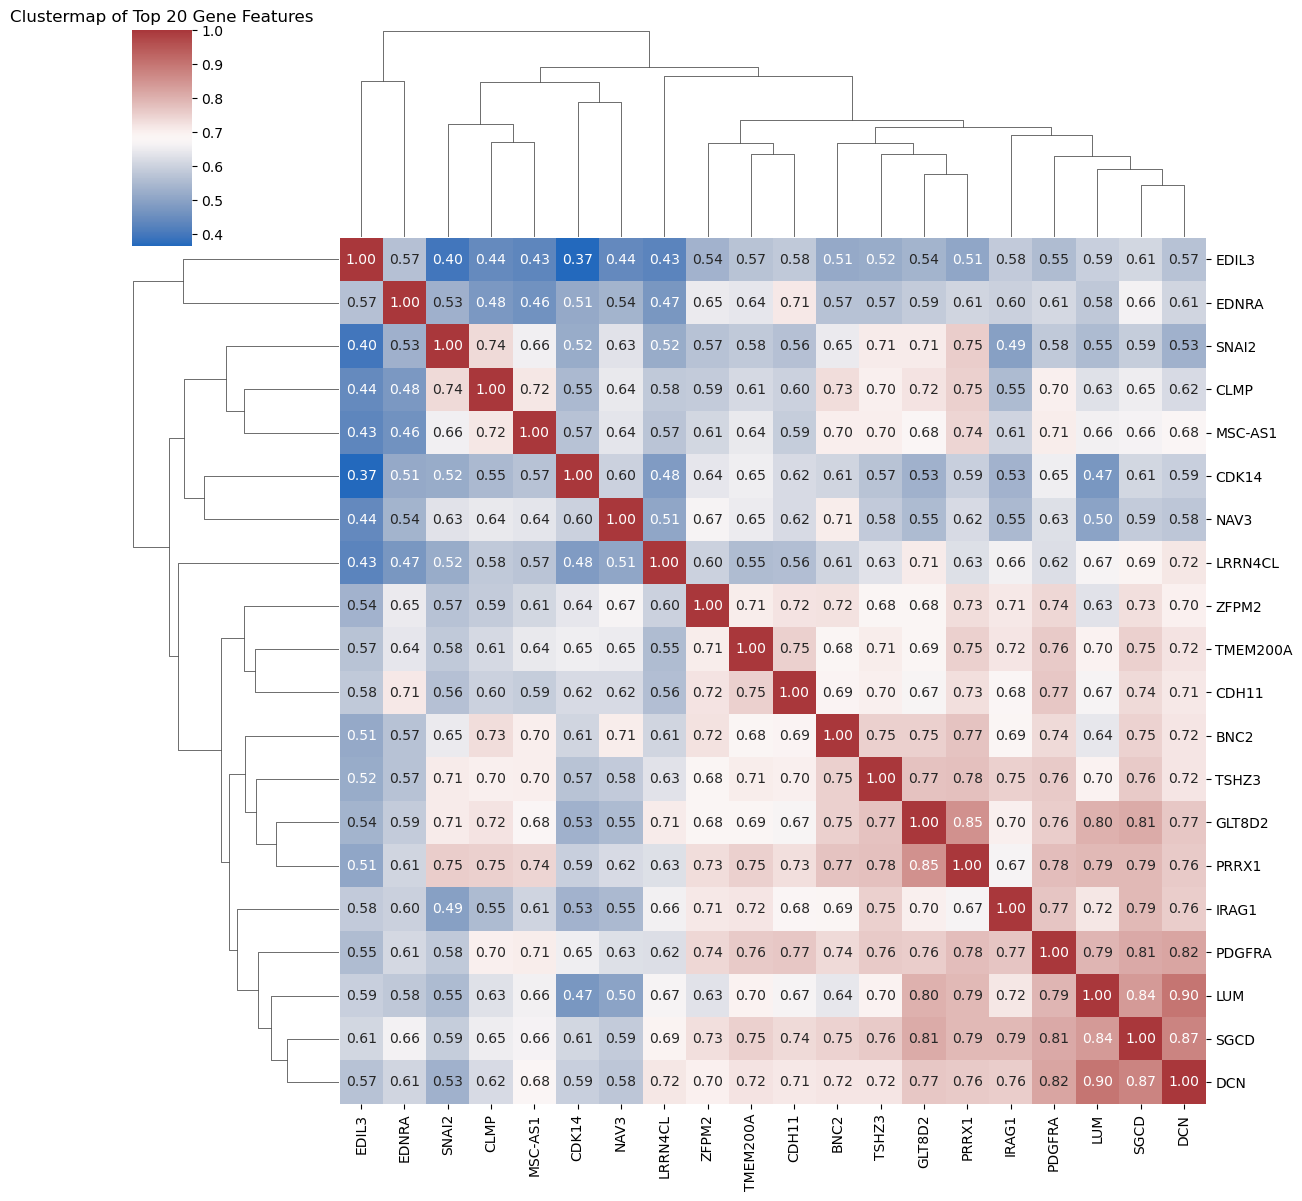

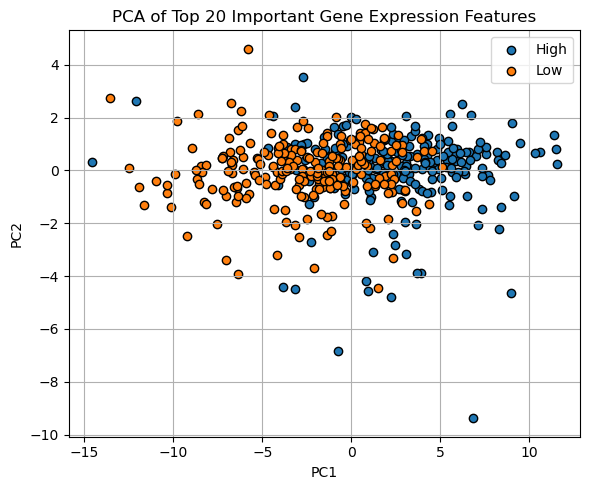

In [ ]:

# Identify the top 20 "gene expression" characteristics (screen from the importance of the characteristics)
gene_importance_df = importance_df[importance_df["type"] == "Gene"]
top_20_gene_df = gene_importance_df.sort_values(by="importance", ascending=False).head(20)
top_20_gene_features = top_20_gene_df["feature"].tolist()

# Obtain the expression data of these genetic characteristics (rows are samples and columns are genes)
top_20_gene_expr_df = X_final[top_20_gene_features]

# Visualize the correlation heat map
plt.figure(figsize=(12, 10))
corr_matrix = top_20_gene_expr_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Top 20 Important Gene Expression Features")
plt.tight_layout()
plt.show()

# Hierarchical clustering visualization
sns.clustermap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", figsize=(12, 12))
plt.title("Clustermap of Top 20 Gene Features")
plt.show()

# PCA dimensionality reduction + visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(top_20_gene_expr_df)

plt.figure(figsize=(6, 5))
for label in np.unique(y_encoded):
    idx = y_encoded == label
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        label=le.inverse_transform([label])[0],
        edgecolor='k'
    )

plt.title("PCA of Top 20 Important Gene Expression Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
print(top_20_gene_features)

['SGCD', 'GLT8D2', 'TMEM200A', 'CDH11', 'ZFPM2', 'LUM', 'CLMP', 'SNAI2', 'LRRN4CL', 'EDIL3', 'CDK14', 'NAV3', 'MSC-AS1', 'BNC2', 'PRRX1', 'IRAG1', 'PDGFRA', 'EDNRA', 'DCN', 'TSHZ3']


In [ ]:
# ========================
# 11. Extract the top 20 most important "gene expression" characteristics of LUAD
# ========================
# Only the gene type is retained
gene_importance_df = importance_df[importance_df["type"] == "Gene"]

# Sort and extract the top 20
top20_gene_df = gene_importance_df.sort_values(by="importance", ascending=False).head(20)


print("Top 20 Gene Expression Features (LUAD):")
print(top20_gene_df)


top20_gene_df.to_csv("LUAD_XGboost_Gene_Importance.csv", index=False)


Top 20 Gene Expression Features (LUAD):
     feature  importance  type
22      SGCD    0.081435  Gene
9     GLT8D2    0.075607  Gene
18  TMEM200A    0.071813  Gene
15     CDH11    0.068229  Gene
21     ZFPM2    0.044380  Gene
13       LUM    0.042605  Gene
20      CLMP    0.041054  Gene
1      SNAI2    0.035007  Gene
25   LRRN4CL    0.032062  Gene
17     EDIL3    0.030991  Gene
2      CDK14    0.023196  Gene
4       NAV3    0.021687  Gene
29   MSC-AS1    0.018885  Gene
23      BNC2    0.015865  Gene
8      PRRX1    0.013549  Gene
5      IRAG1    0.013389  Gene
12    PDGFRA    0.012291  Gene
16     EDNRA    0.011586  Gene
0        DCN    0.011355  Gene
10     TSHZ3    0.009895  Gene



TF PCA主成分对应的重要TF（按绝对贡献排序）:
Component 1: ['BRCA1', 'RXRA', 'NANOG', 'NCOR1', 'NFIC']
Component 2: ['CHD1', 'TBL1XR1', 'CUX1', 'CREB1', 'PHF8']
Component 3: ['ETS1', 'FOXA2', 'GATA1', 'GATA2', 'GATA3']
Component 4: ['MAX', 'SAP30', 'RAD21', 'POLR2A', 'NR2F2']
Component 5: ['POLR2A', 'EGR1', 'CUX1', 'CTCF', 'CREB1']
Component 6: ['CUX1', 'ARID3A', 'HNF4A', 'HNF4G', 'JUN']
Component 7: ['EZH2', 'GATA3', 'MXI1', 'MAX', 'KDM5A']
Component 8: ['ZNF143', 'IRF1', 'GTF2F1', 'H2AFZ', 'HCFC1']
Component 9: ['RNF2', 'REST', 'GTF2B', 'GTF2F1', 'GTF3C2']
Component 10: ['TBP', 'EZH2', 'MAX', 'KDM5B', 'KDM4A']


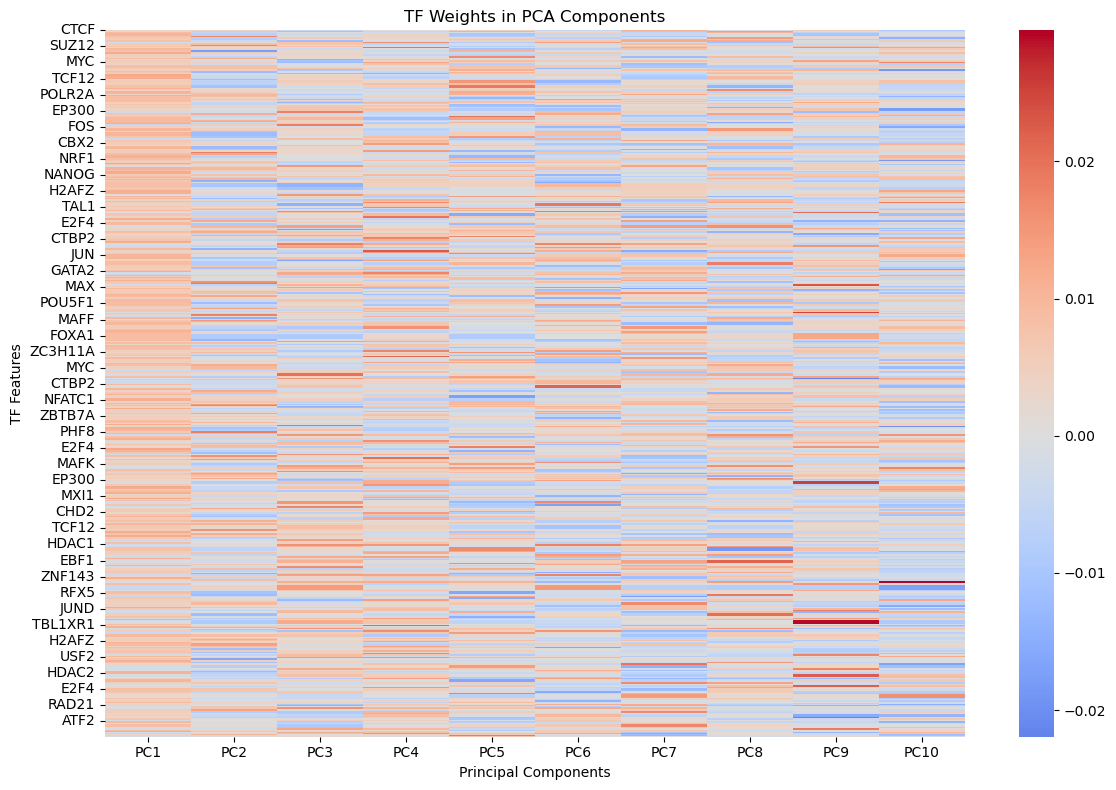

Train accuracy: 0.9613259668508287
Test accuracy : 0.8351648351648352
              precision    recall  f1-score   support

        High       0.81      0.87      0.84        45
         Low       0.86      0.80      0.83        46

    accuracy                           0.84        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.84      0.84      0.84        91



/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


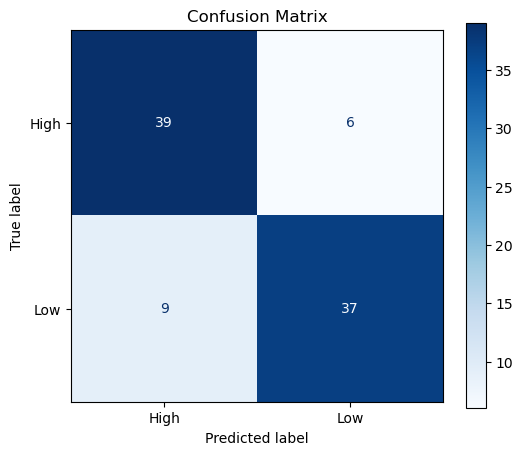

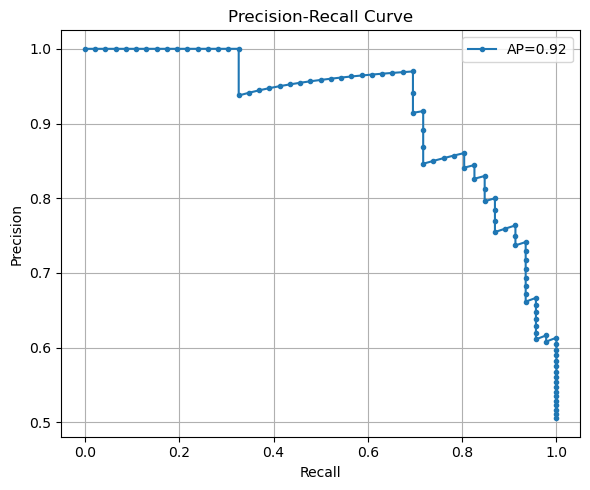

/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-validation accuracy: 0.801 ± 0.032


/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#PCA dimensionality reduction of the TF dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, average_precision_score
import xgboost as xgb

# ========================
# 1. load data
# ========================
label_df = pd.read_csv('LUAD_MIR100HG_Expression_Levels.csv', index_col=0)
gene_expr_df = pd.read_csv('LUAD_Model_Gene_Expression_Features.csv', index_col=0)
methylation_df = pd.read_csv('LUAD_Model_Methylation_Features.csv', index_col=0)
tf_expr_df = pd.read_csv('LUAD_Model_TF_Expression_Features.csv', index_col=0)
gene_expr_test_df = pd.read_csv('LUAD_Model_Gene_Expression_Features_test.csv', index_col=0)
methylation_test_df = pd.read_csv('LUAD_Methylation_Levels_test.csv', index_col=0)


# ========================
# 2. Transpose the feature data
# ========================
gene_expr_df_t = gene_expr_df.T
methylation_df_t = methylation_df.T
tf_expr_df_t = tf_expr_df.T

# ========================
# 3. Obtain public samples
# ========================
common_samples = list(set(gene_expr_df_t.index) & set(methylation_df_t.index) & set(tf_expr_df_t.index))
gene_expr_df_t = gene_expr_df_t.loc[common_samples]
methylation_df_t = methylation_df_t.loc[common_samples]
tf_expr_df_t = tf_expr_df_t.loc[common_samples]

# ========================
# 4. Label Treatment
# ========================
label_df = label_df.reset_index(drop=True).set_index("Sample_ID")
label_df = label_df.reindex(gene_expr_df_t.index)
y = label_df["Group"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Delete MIR100HG to prevent tag leakage
if 'MIR100HG' in gene_expr_df_t.columns:
    gene_expr_df_t = gene_expr_df_t.drop(columns=['MIR100HG'])

# ========================
# 5. Feature Selection and PCA
# ========================
gene_selector = SelectKBest(score_func=f_classif, k=20)
gene_selected = gene_selector.fit_transform(gene_expr_df_t, y_encoded)
gene_selected_df = pd.DataFrame(gene_selected, index=gene_expr_df_t.index,
                                columns=np.array(gene_expr_df_t.columns)[gene_selector.get_support()])

methyl_selector = SelectKBest(score_func=f_classif, k=20)
methyl_selected = methyl_selector.fit_transform(methylation_df_t, y_encoded)
methyl_selected_df = pd.DataFrame(methyl_selected, index=methylation_df_t.index,
                                  columns=np.array(methylation_df_t.columns)[methyl_selector.get_support()])

# TF feature standardization + PCA dimensionality reduction
scaler = StandardScaler()
tf_scaled = scaler.fit_transform(tf_expr_df_t)
pca = PCA(n_components=10, random_state=42)
tf_pca = pca.fit_transform(tf_scaled)
tf_pca_df = pd.DataFrame(tf_pca, index=tf_expr_df_t.index,
                         columns=[f"TF_PC{i+1}" for i in range(tf_pca.shape[1])])

# Print the top 5 TFS that contribute the most in each principal component
top_k = 5
print("")
for i, component in enumerate(pca.components_):
    top_indices = np.argsort(np.abs(component))[-top_k:][::-1]
    top_genes = tf_expr_df_t.columns[top_indices]
    print(f"Component {i+1}: {top_genes.tolist()}")

# Visualization: The heat map shows the weights of TF on each principal component
loading_matrix = pd.DataFrame(pca.components_.T, index=tf_expr_df_t.columns,
                               columns=[f"PC{i+1}" for i in range(pca.n_components_)])
plt.figure(figsize=(12, 8))
sns.heatmap(loading_matrix, cmap="coolwarm", center=0)
plt.title("TF Weights in PCA Components")
plt.xlabel("Principal Components")
plt.ylabel("TF Features")
plt.tight_layout()
plt.show()

# Merge the final features
X_all = pd.concat([gene_selected_df, methyl_selected_df, tf_pca_df], axis=1)

# ========================
# 6. Build the model Pipeline
# ========================
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        reg_alpha=1.0,
        reg_lambda=3.0,
        max_depth=3,
        n_estimators=100,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

# ========================
# 7. Divide the training set/test set
# ========================
X_train, X_test, y_train, y_test = train_test_split(X_all, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Train accuracy:", pipeline.score(X_train, y_train))
print("Test accuracy :", pipeline.score(X_test, y_test))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ========================
# 8. Visual evaluation
# ========================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================
# 9. Cross-validation evaluation
# ========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_result = cross_validate(pipeline, X_all, y_encoded, cv=skf, return_train_score=True)

print("Cross-validation accuracy: %.3f ± %.3f" % (cv_result['test_score'].mean(), cv_result['test_score'].std()))
